# Comparing DPNets to Nyström PCR/RRR

In [1]:
#General imports
import os
from pathlib import Path
import pickle
data_path = Path('data/')
from kooplearn._src.utils import topk
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import scienceplots
from KDEpy import FFTKDE

plt.style.use(['science', 'no-latex', 'std-colors'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

In [25]:
def pt_to_inch(pt):
    return pt/72.27

def figsize(wratio = 1, width_to_height = 3/2, text_width_pt = 397):
    w = pt_to_inch(text_width_pt)*wratio
    h = w/width_to_height
    return (w,h)

def sort_evd(evals, left_fns, right_fns):
    top_evals = topk(evals, len(evals))

    return np.where(top_evals.values > 0, top_evals.values, 0), left_fns[:, top_evals.indices], right_fns[:, top_evals.indices]

def implied_timescales(eigvals, lagtime = 0.2):
    return -lagtime/(np.log(np.abs(eigvals)))

## Loading DPNets Checkpoint

In [3]:
# Wrap the old code into kooplearn
import torch
import schnetpack
from kooplearn.models import DMD
from kooplearn.data import traj_to_contexts
import numpy as np
import matplotlib.pyplot as plt

class Namespace:
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(v, dict):
                setattr(self, k, Namespace(v))
            else:
                setattr(self, k, v)
#Hardcoded configs              
configs = Namespace({
    'data': {
        'cutoff': 5
    },
    'network': {
        'n_rbf': 20,
        'n_atom_basis': 64,
        'n_final_features': 16,
        'n_interactions': 3
    }
})

class SchNet(schnetpack.model.AtomisticModel):
    def __init__(self, configs: Namespace):
        super().__init__(
            input_dtype_str="float32",
            postprocessors=None,
            do_postprocessing=False,
        )
        self.cutoff = configs.data.cutoff
        self.pwise_dist = schnetpack.atomistic.PairwiseDistances()
        self.radial_basis = schnetpack.nn.GaussianRBF(n_rbf=configs.network.n_rbf, cutoff=self.cutoff)
        self.net = schnetpack.representation.SchNet(
            n_atom_basis=configs.network.n_atom_basis, 
            n_interactions=configs.network.n_interactions,
            radial_basis=self.radial_basis,
            cutoff_fn=schnetpack.nn.CosineCutoff(self.cutoff)
        )
        self.final_lin = torch.nn.Linear(configs.network.n_atom_basis, configs.network.n_final_features)
        self.batch_norm = torch.nn.BatchNorm1d(configs.network.n_final_features, affine=False)
    def forward(self, inputs: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        inputs = self.pwise_dist(inputs)
        inputs = self.net(inputs)
        inputs['scalar_representation'] = self.final_lin(inputs['scalar_representation'])
        return inputs['scalar_representation']

In [4]:
db_path = data_path / 'CLN025-0-protein-ALL.db'
cache_path = data_path / 'cache'
nb_list_transform = schnetpack.transform.CachedNeighborList(cache_path, schnetpack.transform.MatScipyNeighborList(cutoff=configs.data.cutoff), keep_cache=True)
in_transforms = [schnetpack.transform.CastTo32(), nb_list_transform]
dataset = schnetpack.data.ASEAtomsData(str(db_path), transforms=in_transforms)
dataloader = schnetpack.data.AtomsLoader(dataset, num_workers=2, persistent_workers=True, batch_size = 1, shuffle=False)

In [5]:
# Restoring checkpoint
state_dict = torch.load('schnet_model_ckpt.pt')
model = SchNet(configs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
# Pre-Compute pwise distances
from tqdm import tqdm
features = []
model.eval()
chunk_idx = 0
chunk_size = 20000
if False:
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        with torch.no_grad():
            feats = model(batch)
        features.append(feats)
        if (batch_idx + 1) % chunk_size == 0:
            features = torch.stack(features, dim=0)
            torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')
            features = []
            chunk_idx += 1
    features = torch.stack(features, dim=0)
    torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')

In [7]:
#Load the features back to memory
num_chunks = len(os.listdir("data/schnet_feats"))
features = []
for i in range(num_chunks):
    features.append(torch.load(f'data/schnet_feats/chunk_{i}.pt'))
features = torch.cat(features, dim=0)
#Use mean embedding as a pooling strategy
mean_embedding = torch.mean(features, dim=1)
mean_embedding = mean_embedding.numpy()

In [26]:
#Init report
report = {}
# Transfer operator fitting
contexts = traj_to_contexts(mean_embedding)
dmd_model = DMD(reduced_rank = False, rank = 16)
dmd_model = dmd_model.fit(contexts)
#Computing eigenvalue decomposition:
data = np.expand_dims(mean_embedding, 1) # (num_samples, 1, num_features)
eig, lf, rf = dmd_model.eig(eval_left_on = data, eval_right_on = data)
eig, lf, rf = sort_evd(eig, lf, rf)
#Populate report
report['DPNets'] = {
    'eigenvalues': eig,
    'left_fns': lf,
    'right_fns': rf
}
#Nystrom
for fname in os.listdir(data_path / 'nystrom_evd'):
    stub = fname.split('_')[0]
    with open(data_path / 'nystrom_evd' / fname, 'rb') as f:
        restored_obj = pickle.load(f)
        eig = restored_obj['eigenvalues']
        lf = restored_obj['left_eigenfunctions']
        rf = restored_obj['right_eigenfunctions']
    eig, lf, rf = sort_evd(eig, lf, rf)
    report["Nys-" + stub] = {
        'eigenvalues': eig,
        'left_fns': lf,
        'right_fns': rf
    }

Fitted DMD model. Lookback length set to 1


## Pretty print eigenvalues

In [28]:
timescales = {}
for model in report.keys():
    timescales[model] = implied_timescales(report[model]['eigenvalues'])

/tmp/ipykernel_3101059/3674049209.py:15: RuntimeWarning: divide by zero encountered in log
  return -lagtime/(np.log(np.abs(eigvals)))


In [29]:
print("Implied Timescales (ns)")
print(tabulate(timescales, headers="keys", floatfmt=".2f"))

Implied Timescales (ns)
  DPNets    Nys-RRR    Nys-PCR
--------  ---------  ---------
  135.62      56.27      72.98
   17.59       0.89       5.27
    8.05       0.74       1.50
    3.83       0.01       0.84
    3.63       0.01       0.77
    3.62       0.01       0.71
    2.63       0.01       0.55
    2.33       0.00       0.50
    1.61       0.00       0.45
    1.51       0.00       0.41
    1.33       0.00       0.33
    1.30       0.00       0.22
    1.13       0.00       0.20
    1.08       0.00       0.19
    0.81       0.00       0.18
    0.57       0.00       0.08


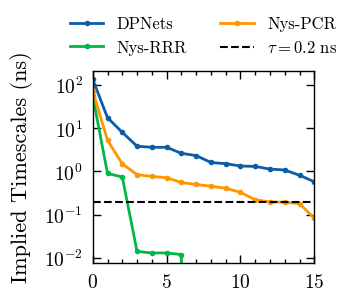

In [35]:
fig, ax = plt.subplots(figsize=figsize(wratio = .33, width_to_height = 1.1), dpi=200)
for model in report.keys():
    ax.plot(timescales[model], '.-', label=model, markersize=2)
ax.axhline(0.2, color='k', linestyle='--', lw=0.75, label=r'$\tau = 0.2$ ns')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=2, fontsize=6)
ax.set_ylabel('Implied Timescales (ns)')
ax.set_yticks([0.01, 0.1, 1, 10, 100])
fig.tight_layout()
fig.savefig("figures/implied_timescales.png")

## Eigenfunc Analysis

In [44]:
bloomberg_colors = [
    '#000000',
    '#ff433d',
    '#0068ff',
    '#4af6c3',
    '#fb8b1e'
]

In [237]:
def free_energy_surface(model_stub: str, eig_idx, bw = 'silverman'):
    lfns = report[model_stub]['left_fns']
    rfns = report[model_stub]['right_fns']
    lfns = lfns.real
    rfns = rfns.real

    eig = report[model_stub]['eigenvalues']
    lfn = lfns[:, eig_idx]
    rfn = rfns[:, eig_idx]

    #boltzmann_dist = np.where(lfns[:, 0]>0, lfns[:, 0], 1e-8)

    if lfn.ndim == 1:
        pass
        #lfn = lfn/boltzmann_dist #Normalization
    elif lfn.ndim == 2:
        pass
        #lfn = lfn/boltzmann_dist[:, None] #Normalization
    else:
        raise ValueError("Only 1 or 2 eigenvalue indices are supported")
    x, kde = FFTKDE(bw=bw).fit(lfn).evaluate(2**8) #256 bins
    fesl = -np.log(kde)
    x, kde = FFTKDE(bw=bw).fit(rfn).evaluate(2**8) #256 bins
    fesr = -np.log(kde)
    return x, fesl, fesr

In [244]:
eval_idx = np.array([0])
model_stub = 'Nys-RRR' 
x, fesl, fesr = free_energy_surface(model_stub, eval_idx)

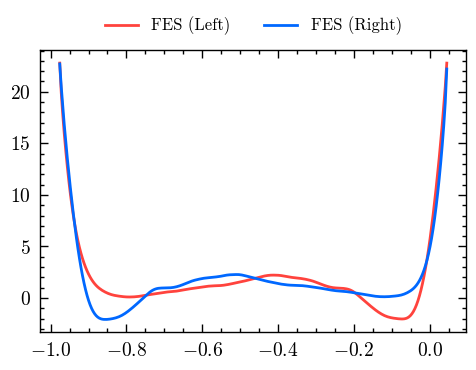

In [245]:
from scipy.signal import argrelextrema
# for local minima
fig, ax = plt.subplots(figsize=figsize(wratio = .5, width_to_height = 3/2), dpi=200)

ax.plot(x, fesl, label='FES (Left)', lw=1, c = bloomberg_colors[1]);
ax.plot(x, fesr, label='FES (Right)', lw=1, c = bloomberg_colors[2]);
#ax.scatter(x[local_minima], fes[local_minima], label='Local minima', c = bloomberg_colors[1], s=10);
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=2, fontsize=6)

### DPNets vs. Nystrom
So far:  
- $\mathcal{P}$ score is higher (can be estimated just by summing the squared eigenvalues, as the system is self-adjoint)
- The implied timescales are all above the lagtime. Below it, any estimated eigenvalue is pure noise.
- Better estimation of transition path time (compared to the reference)
- Better estimation of the folding enthalpy (compared to the reference)

Missing:
- (Hopefully?) Nystrom only recover the folding-unfolding transition, while DPNets also recover the one by Bonati et al.

In [250]:
def compute_enthalpy(model:str, T = 340):
    k_B = 0.0019872041
    kBT = k_B*T
    fu_idx = 1
    if model == 'Nys-RRR':
        fu_idx = 0
    _, fes, _ = free_energy_surface(model, fu_idx)
    local_minima_idx = argrelextrema(fes, np.less)
    fes = fes[local_minima_idx]
    fes = fes - fes.min()
    fes = np.sort(fes)
    return -fes[1]*kBT

In [251]:
ordered_models = ['DPNets', 'Nys-PCR', 'Nys-RRR']
print("--------------------------------------------------------------------")
print("Projection score (higher is better):")
for model in ordered_models:
    ev = report[model]['eigenvalues']
    score = np.sum(np.abs(ev)**2)
    print(f"  {model}: {score:.2f}")
print("--------------------------------------------------------------------")
print("Transition-path time")
print("  Reference (Lindorff-Larsen et al. 2011): 40 ns")
for model in ordered_models:
    print(f"  {model}: {timescales[model][1]:.2f} ns")
print("--------------------------------------------------------------------")
print("Folding enthalpy (T = 340K)")
print("  Reference (Lindorff-Larsen et al. 2011): -6.1 kcal/mol")
for model in ordered_models:
    try:
        print(f"  {model}: {compute_enthalpy(model):.2f} kcal/mol")
    except:
        print(f"  {model}: N/A")
print("--------------------------------------------------------------------")

--------------------------------------------------------------------
Projection score (higher is better):
  DPNets: 12.84
  Nys-PCR: 7.02
  Nys-RRR: 2.22
--------------------------------------------------------------------
Transition-path time
  Reference (Lindorff-Larsen et al. 2011): 40 ns
  DPNets: 17.59 ns
  Nys-PCR: 5.27 ns
  Nys-RRR: 0.89 ns
--------------------------------------------------------------------
Folding enthalpy (T = 340K)
  Reference (Lindorff-Larsen et al. 2011): -6.1 kcal/mol
  DPNets: -1.97 kcal/mol
  Nys-PCR: -1.76 kcal/mol
  Nys-RRR: -1.44 kcal/mol
--------------------------------------------------------------------


/tmp/ipykernel_3101059/909959604.py:22: RuntimeWarning: invalid value encountered in log
  fesl = -np.log(kde)
/tmp/ipykernel_3101059/909959604.py:24: RuntimeWarning: invalid value encountered in log
  fesr = -np.log(kde)
/tmp/ipykernel_3101059/909959604.py:22: RuntimeWarning: invalid value encountered in log
  fesl = -np.log(kde)
/tmp/ipykernel_3101059/909959604.py:24: RuntimeWarning: invalid value encountered in log
  fesr = -np.log(kde)


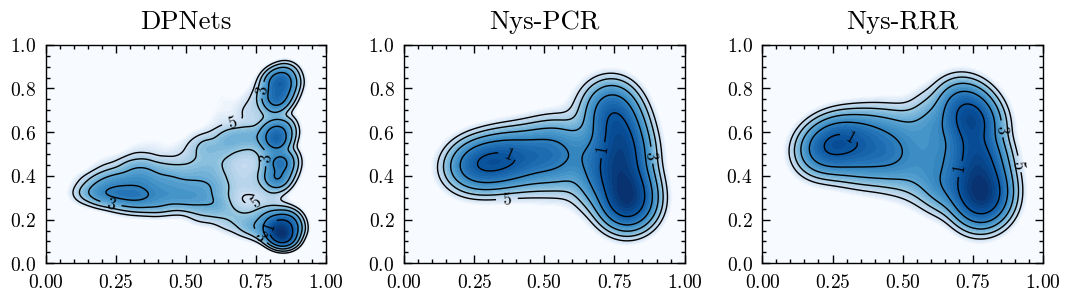

In [303]:
#Plot free energy surfaces
fig, axes = plt.subplots(1, 3, figsize=figsize(wratio = 1, width_to_height = 3/0.9), dpi=200)
bw = [0.1, 0.05, 0.05]
k_B = 0.0019872041
T = 340
for ax_idx, model in enumerate(ordered_models):
    ax = axes[ax_idx]
    eig_idx = np.array([1, 2])
    if model == 'Nys-RRR':
        eig_idx = eig_idx -1
    x, fes, _ = free_energy_surface(model, eig_idx, bw = bw[ax_idx])
    #Center x
    xmx = x.max(axis=0)
    xmn = x.min(axis=0)
    x = (x - xmn)/(xmx - xmn)
    fes = np.where(np.isnan(fes), np.inf, fes)
    fes = fes - fes.min()
    fes = fes*k_B*T
    energy_cap = 10
    fes = np.where(fes < energy_cap, fes, energy_cap)
    ax.tricontourf(x[:, 0], x[:, 1], fes, levels = np.linspace(0, 20, 100), cmap='Blues_r', vmax=6.5);
    ctr = ax.tricontour(x[:, 0], x[:, 1], fes, levels = [1, 2, 3, 4, 5], linewidths=0.5, colors='k');
    ax.set_title(model)
    ax.clabel(ctr, [1, 3, 5], inline=1, fontsize=6)
fig.tight_layout()
fig.savefig("figures/fes.png")